<a href="https://colab.research.google.com/github/pf-alt/Algebra-II/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY:GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY:GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY:GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'BrlR' #@param {type:"string"}
# number of models to use
num_relax = 5 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname BrlR_f222f
sequence GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY:GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY:GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWERFIPREHEIAGKHDPEVSYGICAQQPNGEFHYVAGFEVQEGWPVPEGMVRFQVPAQKYAVFTHKGTAPQIAESFQAIYSHLLAERGLEPKAGVDFEYYDQRFRGPLDPNSQVDLYIPIY:GSMLTIGQLARIFEISTKTLRHYDAIGLFVPARTGSDNGYRYYQPEQIEQLSRILALRRLDVPLEAIDRLKRDGALDDPQRLRHFLQRHQHTLREEISARQRLLAELDRTLATLAHWRIRNMHARIVERPAFSVVGMEYFGSAPGDTIGQLWE

In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
installing conda...
installing amber...
CPU times: user 3.25 ms, sys: 3.04 ms, total: 6.3 ms
Wall time: 55.8 s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "alphafold2_multimer_v3" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "24" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = True #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "512:1024" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 4 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = True #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-11-30 03:24:08,511 Running on GPU
2025-11-30 03:24:08,804 Found 6 citations for tools or databases
2025-11-30 03:24:08,804 Query 1/1: BrlR_f222f (length 1088)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


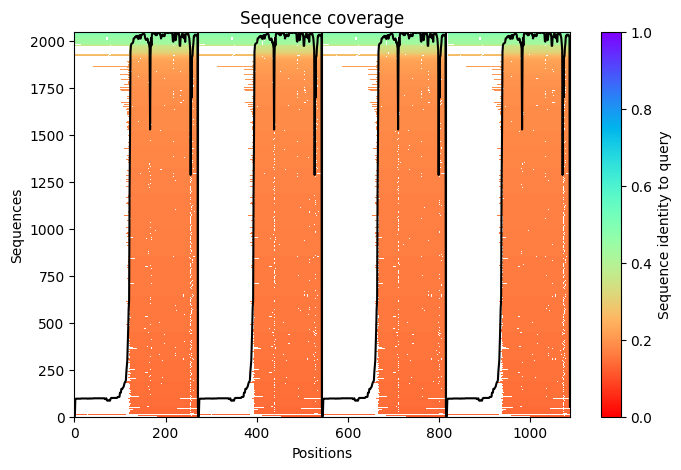

2025-11-30 03:24:12,968 Setting max_seq=512, max_extra_seq=1024


/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-11-30 03:26:03,683 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=77.3 pTM=0.319 ipTM=0.251
2025-11-30 03:27:17,845 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=77.6 pTM=0.301 ipTM=0.234 tol=16
2025-11-30 03:27:41,098 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=77.9 pTM=0.387 ipTM=0.338 tol=4.77
2025-11-30 03:28:04,340 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=90.8 pTM=0.78 ipTM=0.778 tol=9.19
2025-11-30 03:28:27,564 alphafold2_multimer_v3_model_1_seed_000 recycle=4 pLDDT=89.6 pTM=0.797 ipTM=0.795 tol=0.812
2025-11-30 03:28:50,807 alphafold2_multimer_v3_model_1_seed_000 recycle=5 pLDDT=90.4 pTM=0.821 ipTM=0.817 tol=0.287
2025-11-30 03:28:55,083 alphafold2_multimer_v3_model_1_seed_000 took 273.7s (5 recycles)


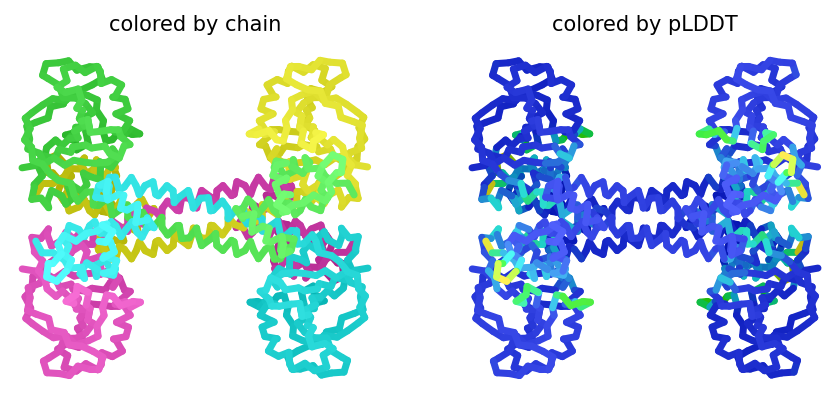

2025-11-30 03:29:19,689 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=78.4 pTM=0.349 ipTM=0.284
2025-11-30 03:29:42,902 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=85.3 pTM=0.649 ipTM=0.632 tol=9.36
2025-11-30 03:30:06,169 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=88.8 pTM=0.771 ipTM=0.764 tol=3.33
2025-11-30 03:30:29,490 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=91.2 pTM=0.839 ipTM=0.837 tol=0.444
2025-11-30 03:30:31,611 alphafold2_multimer_v3_model_2_seed_000 took 95.2s (3 recycles)


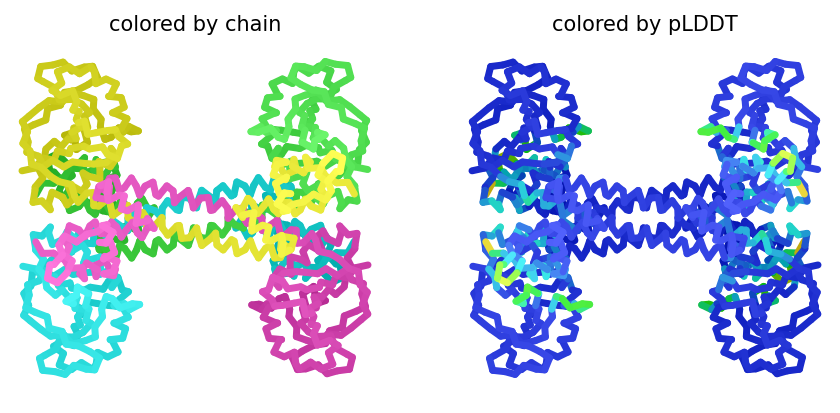

2025-11-30 03:30:56,262 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=75.4 pTM=0.291 ipTM=0.228
2025-11-30 03:31:19,566 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=77.2 pTM=0.3 ipTM=0.226 tol=14.4
2025-11-30 03:31:42,730 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=86.9 pTM=0.682 ipTM=0.669 tol=4.46
2025-11-30 03:32:05,930 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=89.2 pTM=0.766 ipTM=0.757 tol=1.38
2025-11-30 03:32:29,121 alphafold2_multimer_v3_model_3_seed_000 recycle=4 pLDDT=89.7 pTM=0.777 ipTM=0.768 tol=0.325
2025-11-30 03:32:31,234 alphafold2_multimer_v3_model_3_seed_000 took 118.3s (4 recycles)


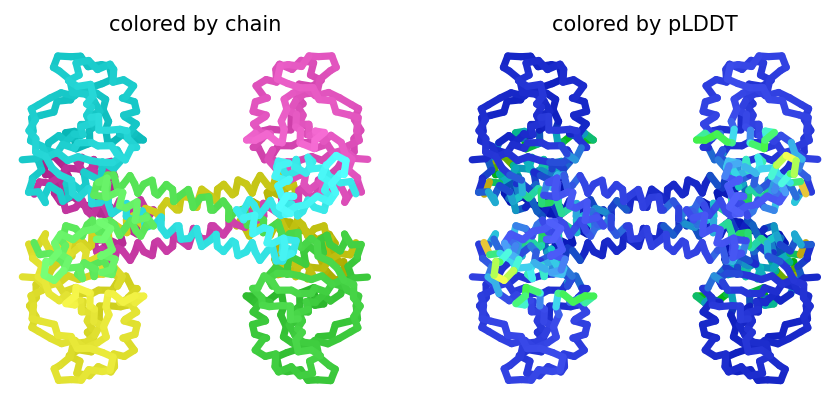

2025-11-30 03:32:55,949 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=75.7 pTM=0.3 ipTM=0.23
2025-11-30 03:33:19,376 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=76.9 pTM=0.286 ipTM=0.217 tol=14.7
2025-11-30 03:33:42,643 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=80.2 pTM=0.358 ipTM=0.286 tol=10.5
2025-11-30 03:34:05,866 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=90.1 pTM=0.741 ipTM=0.728 tol=6.63
2025-11-30 03:34:29,078 alphafold2_multimer_v3_model_4_seed_000 recycle=4 pLDDT=89.8 pTM=0.769 ipTM=0.76 tol=0.801
2025-11-30 03:34:52,317 alphafold2_multimer_v3_model_4_seed_000 recycle=5 pLDDT=89.9 pTM=0.779 ipTM=0.77 tol=0.221
2025-11-30 03:34:54,431 alphafold2_multimer_v3_model_4_seed_000 took 141.9s (5 recycles)


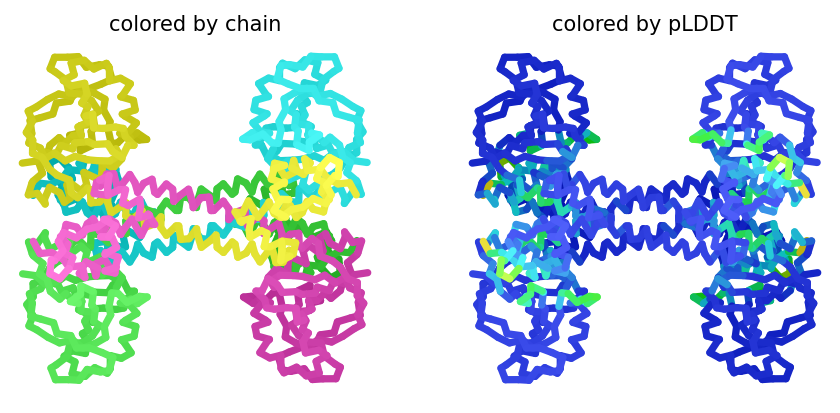

2025-11-30 03:35:19,210 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=76.4 pTM=0.279 ipTM=0.209
2025-11-30 03:35:42,469 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=76.1 pTM=0.342 ipTM=0.29 tol=7.8
2025-11-30 03:36:05,677 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=84.3 pTM=0.631 ipTM=0.607 tol=2.94
2025-11-30 03:36:28,864 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=86.5 pTM=0.71 ipTM=0.694 tol=0.866
2025-11-30 03:36:52,075 alphafold2_multimer_v3_model_5_seed_000 recycle=4 pLDDT=88.4 pTM=0.756 ipTM=0.746 tol=0.475
2025-11-30 03:36:54,179 alphafold2_multimer_v3_model_5_seed_000 took 118.4s (4 recycles)


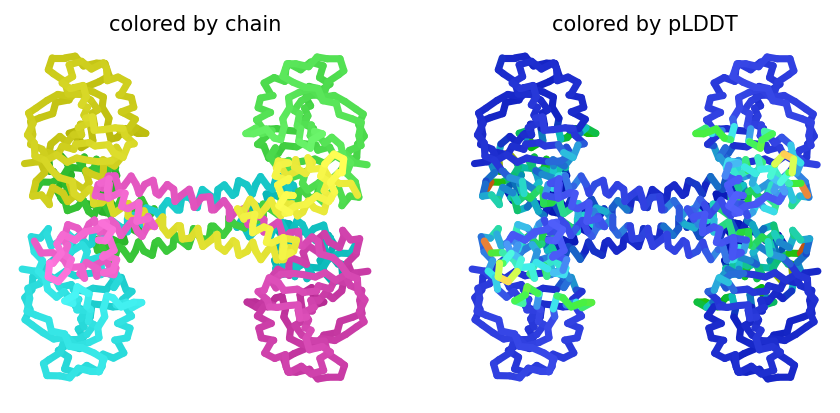

2025-11-30 03:37:18,733 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=77.8 pTM=0.338 ipTM=0.274
2025-11-30 03:37:41,995 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=89.2 pTM=0.766 ipTM=0.76 tol=13.4
2025-11-30 03:38:05,298 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=91.3 pTM=0.843 ipTM=0.842 tol=1.11
2025-11-30 03:38:28,578 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=91.4 pTM=0.848 ipTM=0.846 tol=0.498
2025-11-30 03:38:30,700 alphafold2_multimer_v3_model_1_seed_001 took 95.2s (3 recycles)


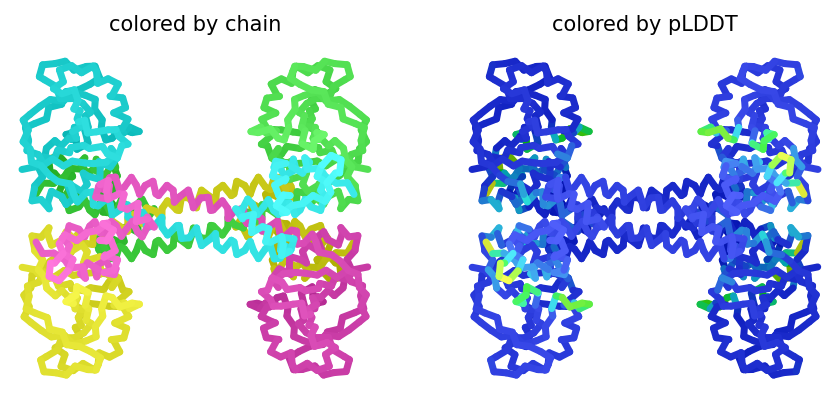

2025-11-30 03:38:55,340 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=76 pTM=0.302 ipTM=0.234
2025-11-30 03:39:18,560 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=86.8 pTM=0.697 ipTM=0.679 tol=14.9
2025-11-30 03:39:41,834 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=89.9 pTM=0.797 ipTM=0.79 tol=3.04
2025-11-30 03:40:05,099 alphafold2_multimer_v3_model_2_seed_001 recycle=3 pLDDT=90.5 pTM=0.817 ipTM=0.812 tol=0.501
2025-11-30 03:40:28,376 alphafold2_multimer_v3_model_2_seed_001 recycle=4 pLDDT=91.4 pTM=0.832 ipTM=0.827 tol=0.42
2025-11-30 03:40:30,500 alphafold2_multimer_v3_model_2_seed_001 took 118.5s (4 recycles)


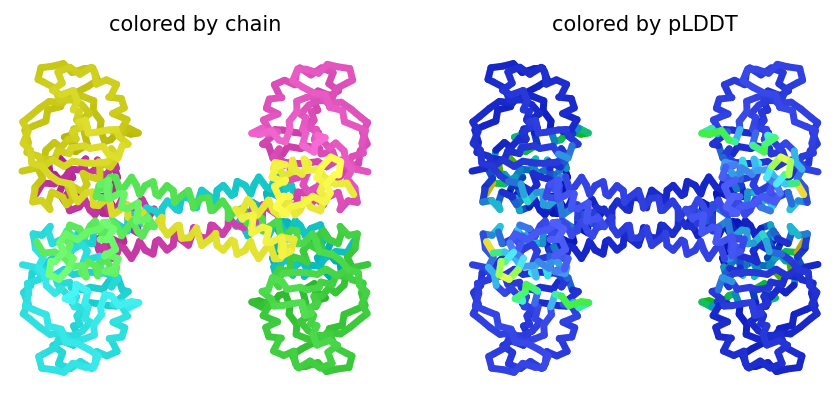

2025-11-30 03:40:55,104 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=74.4 pTM=0.3 ipTM=0.237
2025-11-30 03:41:18,294 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=88.1 pTM=0.725 ipTM=0.721 tol=14.2
2025-11-30 03:41:41,497 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=89.4 pTM=0.778 ipTM=0.767 tol=0.976
2025-11-30 03:42:04,728 alphafold2_multimer_v3_model_3_seed_001 recycle=3 pLDDT=90 pTM=0.786 ipTM=0.776 tol=0.31
2025-11-30 03:42:06,856 alphafold2_multimer_v3_model_3_seed_001 took 95.1s (3 recycles)


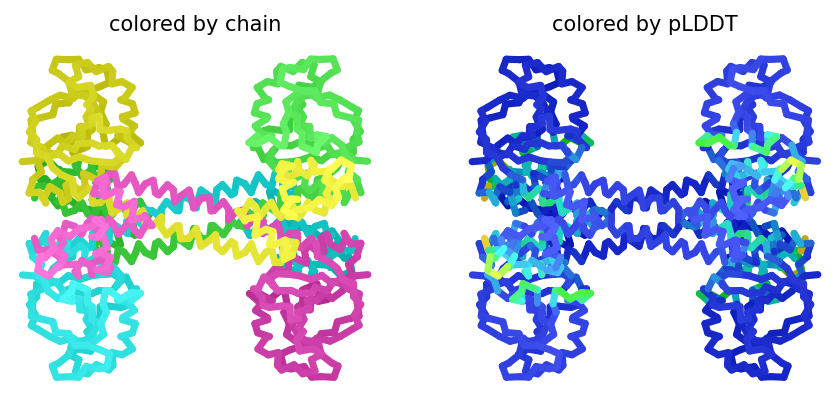

2025-11-30 03:42:31,531 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=74.5 pTM=0.3 ipTM=0.232
2025-11-30 03:42:55,036 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=78.6 pTM=0.289 ipTM=0.219 tol=17.5
2025-11-30 03:43:18,404 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=78.8 pTM=0.308 ipTM=0.235 tol=4.81
2025-11-30 03:43:41,710 alphafold2_multimer_v3_model_4_seed_001 recycle=3 pLDDT=80.2 pTM=0.347 ipTM=0.26 tol=2.43
2025-11-30 03:44:05,006 alphafold2_multimer_v3_model_4_seed_001 recycle=4 pLDDT=80.8 pTM=0.352 ipTM=0.26 tol=1.51
2025-11-30 03:44:28,308 alphafold2_multimer_v3_model_4_seed_001 recycle=5 pLDDT=80.8 pTM=0.361 ipTM=0.266 tol=0.946
2025-11-30 03:44:51,613 alphafold2_multimer_v3_model_4_seed_001 recycle=6 pLDDT=81.1 pTM=0.366 ipTM=0.265 tol=0.471
2025-11-30 03:44:53,710 alphafold2_multimer_v3_model_4_seed_001 took 165.5s (6 recycles)


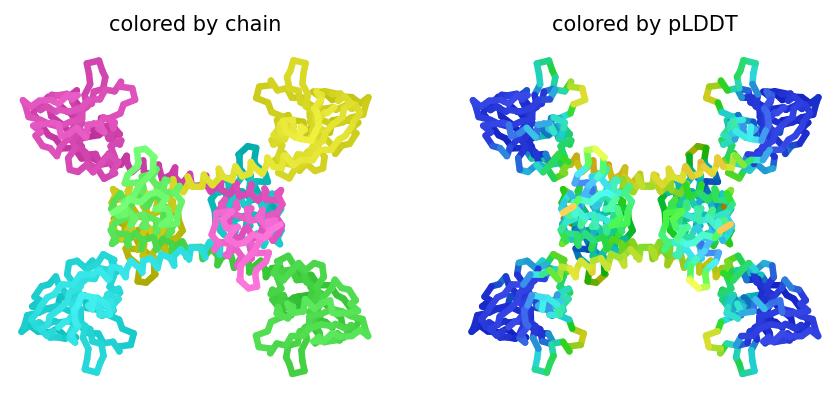

2025-11-30 03:45:18,392 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=77.2 pTM=0.297 ipTM=0.231
2025-11-30 03:45:41,598 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=85 pTM=0.634 ipTM=0.618 tol=7.32
2025-11-30 03:46:04,794 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=87.6 pTM=0.731 ipTM=0.719 tol=0.926
2025-11-30 03:46:28,018 alphafold2_multimer_v3_model_5_seed_001 recycle=3 pLDDT=88.1 pTM=0.747 ipTM=0.734 tol=0.373
2025-11-30 03:46:30,127 alphafold2_multimer_v3_model_5_seed_001 took 95.1s (3 recycles)


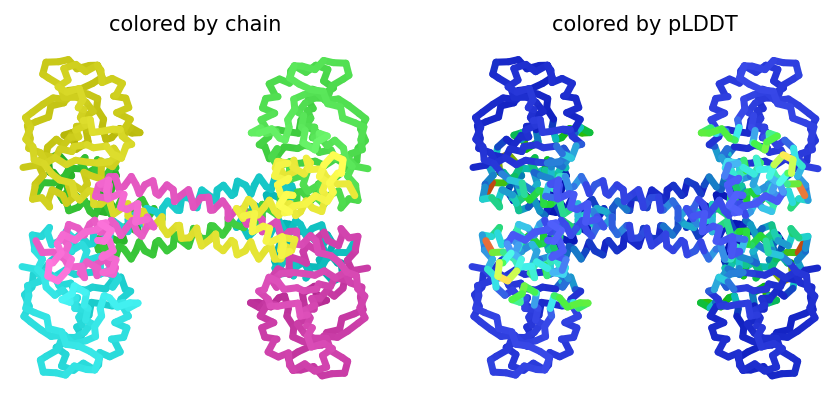

2025-11-30 03:46:54,800 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=77.5 pTM=0.301 ipTM=0.236
2025-11-30 03:47:18,018 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=81.6 pTM=0.51 ipTM=0.481 tol=13.3
2025-11-30 03:47:41,252 alphafold2_multimer_v3_model_1_seed_002 recycle=2 pLDDT=88.9 pTM=0.788 ipTM=0.785 tol=1.52
2025-11-30 03:48:04,511 alphafold2_multimer_v3_model_1_seed_002 recycle=3 pLDDT=90.1 pTM=0.818 ipTM=0.814 tol=0.587
2025-11-30 03:48:27,785 alphafold2_multimer_v3_model_1_seed_002 recycle=4 pLDDT=91.1 pTM=0.846 ipTM=0.843 tol=0.348
2025-11-30 03:48:29,904 alphafold2_multimer_v3_model_1_seed_002 took 118.5s (4 recycles)


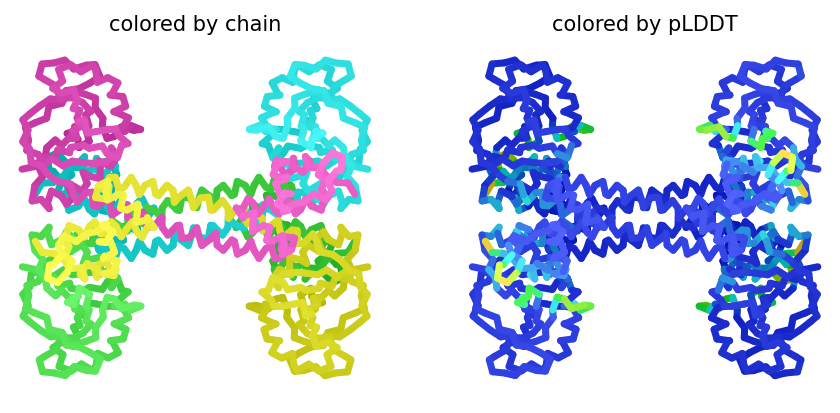

2025-11-30 03:48:54,496 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=76.4 pTM=0.323 ipTM=0.262
2025-11-30 03:49:17,792 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=77.4 pTM=0.354 ipTM=0.288 tol=7.36
2025-11-30 03:49:40,988 alphafold2_multimer_v3_model_2_seed_002 recycle=2 pLDDT=84.6 pTM=0.62 ipTM=0.585 tol=13.1
2025-11-30 03:50:04,181 alphafold2_multimer_v3_model_2_seed_002 recycle=3 pLDDT=87.3 pTM=0.713 ipTM=0.696 tol=1.24
2025-11-30 03:50:27,407 alphafold2_multimer_v3_model_2_seed_002 recycle=4 pLDDT=88.9 pTM=0.762 ipTM=0.751 tol=0.777
2025-11-30 03:50:50,628 alphafold2_multimer_v3_model_2_seed_002 recycle=5 pLDDT=89.7 pTM=0.785 ipTM=0.777 tol=0.433
2025-11-30 03:50:52,762 alphafold2_multimer_v3_model_2_seed_002 took 141.5s (5 recycles)


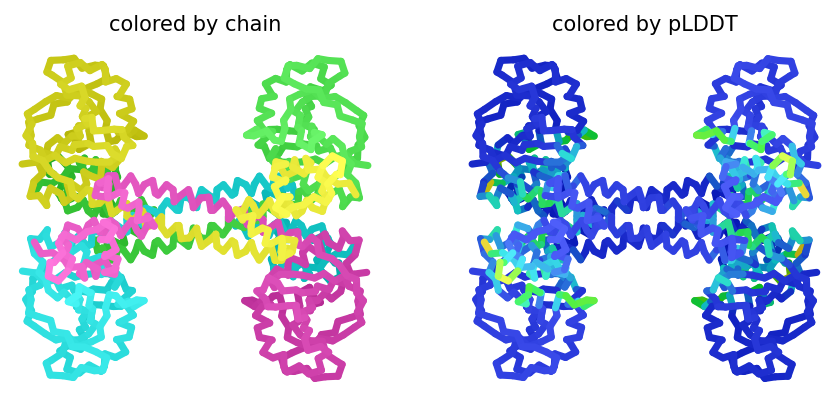

2025-11-30 03:51:17,458 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=75 pTM=0.292 ipTM=0.23
2025-11-30 03:51:40,630 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=81.4 pTM=0.514 ipTM=0.481 tol=13.8
2025-11-30 03:52:03,854 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=88.9 pTM=0.762 ipTM=0.75 tol=2.82
2025-11-30 03:52:27,048 alphafold2_multimer_v3_model_3_seed_002 recycle=3 pLDDT=89.2 pTM=0.773 ipTM=0.762 tol=0.938
2025-11-30 03:52:50,263 alphafold2_multimer_v3_model_3_seed_002 recycle=4 pLDDT=90.1 pTM=0.79 ipTM=0.781 tol=0.368
2025-11-30 03:52:52,396 alphafold2_multimer_v3_model_3_seed_002 took 118.3s (4 recycles)


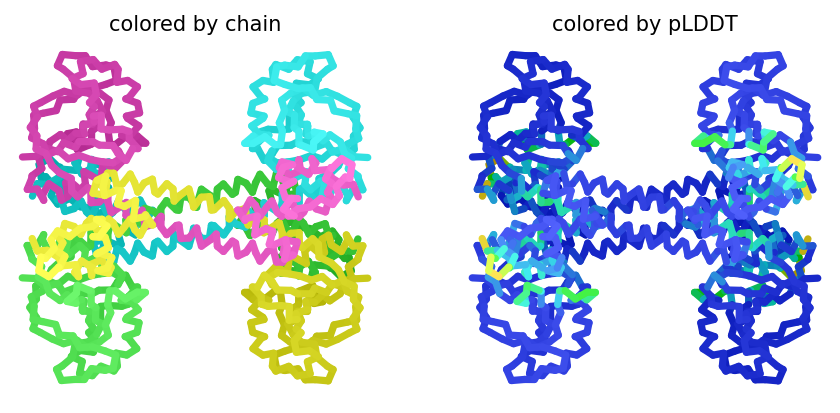

2025-11-30 03:53:17,094 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=78.6 pTM=0.372 ipTM=0.298
2025-11-30 03:53:40,349 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=89.2 pTM=0.715 ipTM=0.709 tol=11.3
2025-11-30 03:54:03,632 alphafold2_multimer_v3_model_4_seed_002 recycle=2 pLDDT=90.9 pTM=0.818 ipTM=0.818 tol=1.09
2025-11-30 03:54:26,967 alphafold2_multimer_v3_model_4_seed_002 recycle=3 pLDDT=91.8 pTM=0.841 ipTM=0.839 tol=0.385
2025-11-30 03:54:29,083 alphafold2_multimer_v3_model_4_seed_002 took 95.4s (3 recycles)


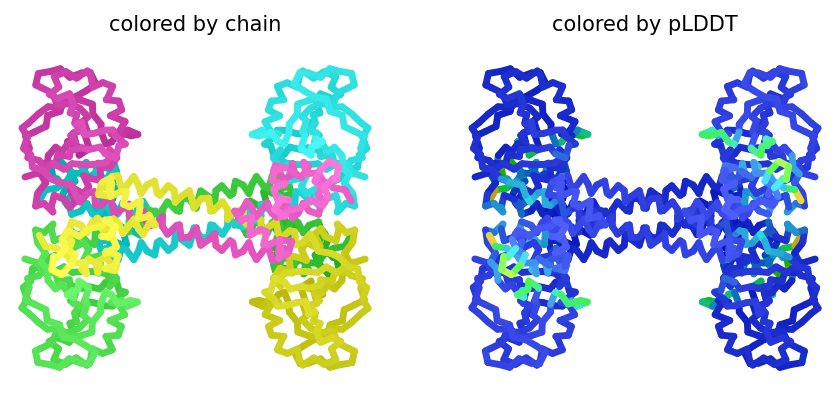

2025-11-30 03:54:53,749 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=77.1 pTM=0.302 ipTM=0.234
2025-11-30 03:55:16,977 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=76.4 pTM=0.351 ipTM=0.302 tol=12.8
2025-11-30 03:55:40,182 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=85.2 pTM=0.654 ipTM=0.633 tol=2.46
2025-11-30 03:56:03,386 alphafold2_multimer_v3_model_5_seed_002 recycle=3 pLDDT=86.6 pTM=0.71 ipTM=0.694 tol=0.902
2025-11-30 03:56:26,613 alphafold2_multimer_v3_model_5_seed_002 recycle=4 pLDDT=88.4 pTM=0.755 ipTM=0.745 tol=0.695
2025-11-30 03:56:49,839 alphafold2_multimer_v3_model_5_seed_002 recycle=5 pLDDT=88.9 pTM=0.767 ipTM=0.756 tol=0.709
2025-11-30 03:57:13,074 alphafold2_multimer_v3_model_5_seed_002 recycle=6 pLDDT=89.3 pTM=0.777 ipTM=0.766 tol=0.69
2025-11-30 03:57:36,334 alphafold2_multimer_v3_model_5_seed_002 recycle=7 pLDDT=89.4 pTM=0.778 ipTM=0.767 tol=0.642
2025-11-30 03:57:59,584 alphafold2_multimer_v3_model_5_seed_002 recycle=8 pLDDT=89.9 p

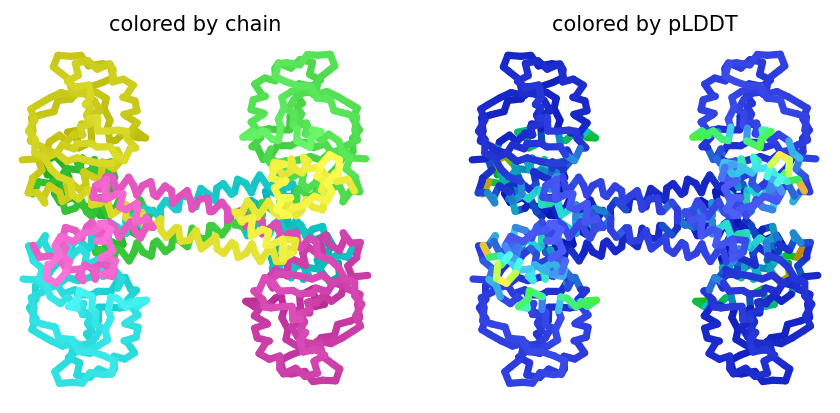

2025-11-30 04:00:46,271 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=77.8 pTM=0.3 ipTM=0.233
2025-11-30 04:01:09,498 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=80.1 pTM=0.442 ipTM=0.402 tol=13.7
2025-11-30 04:01:32,746 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=90 pTM=0.811 ipTM=0.809 tol=2.78
2025-11-30 04:01:55,971 alphafold2_multimer_v3_model_1_seed_003 recycle=3 pLDDT=89.8 pTM=0.808 ipTM=0.805 tol=0.583
2025-11-30 04:02:19,233 alphafold2_multimer_v3_model_1_seed_003 recycle=4 pLDDT=91 pTM=0.839 ipTM=0.835 tol=0.152
2025-11-30 04:02:21,346 alphafold2_multimer_v3_model_1_seed_003 took 118.5s (4 recycles)


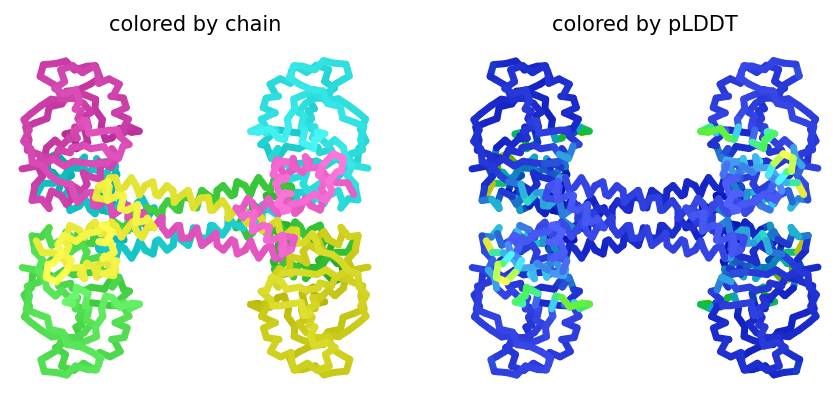

2025-11-30 04:02:46,002 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=77.4 pTM=0.309 ipTM=0.241
2025-11-30 04:03:09,221 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=87.5 pTM=0.717 ipTM=0.708 tol=9.51
2025-11-30 04:03:32,447 alphafold2_multimer_v3_model_2_seed_003 recycle=2 pLDDT=88.4 pTM=0.762 ipTM=0.752 tol=1.83
2025-11-30 04:03:55,661 alphafold2_multimer_v3_model_2_seed_003 recycle=3 pLDDT=89.2 pTM=0.774 ipTM=0.763 tol=0.38
2025-11-30 04:03:57,782 alphafold2_multimer_v3_model_2_seed_003 took 95.1s (3 recycles)


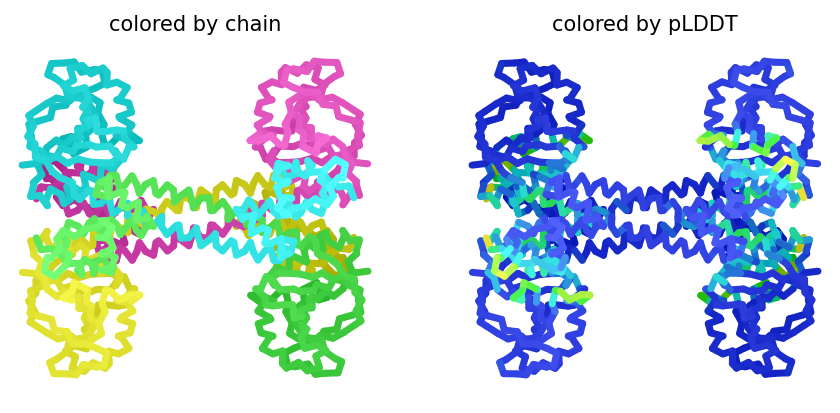

2025-11-30 04:04:22,425 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=77.9 pTM=0.312 ipTM=0.241
2025-11-30 04:04:45,691 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=78.5 pTM=0.322 ipTM=0.254 tol=11.3
2025-11-30 04:05:08,896 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=88.7 pTM=0.749 ipTM=0.739 tol=7.41
2025-11-30 04:05:32,087 alphafold2_multimer_v3_model_3_seed_003 recycle=3 pLDDT=89.2 pTM=0.775 ipTM=0.763 tol=0.873
2025-11-30 04:05:55,313 alphafold2_multimer_v3_model_3_seed_003 recycle=4 pLDDT=90.7 pTM=0.803 ipTM=0.793 tol=0.246
2025-11-30 04:05:57,420 alphafold2_multimer_v3_model_3_seed_003 took 118.3s (4 recycles)


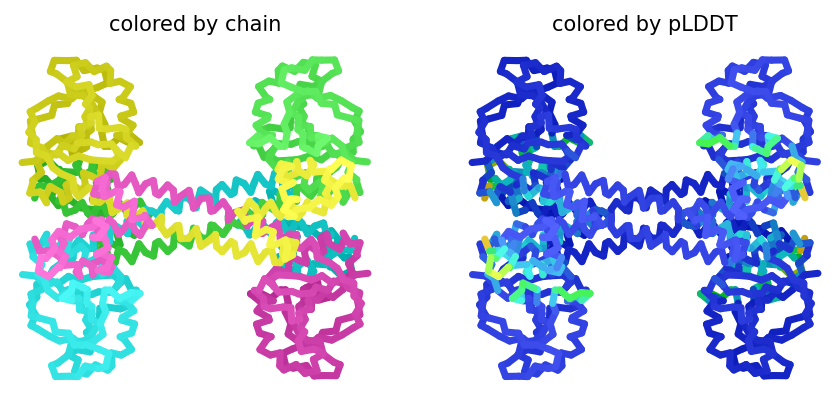

2025-11-30 04:06:22,022 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=77.8 pTM=0.391 ipTM=0.298
2025-11-30 04:06:45,248 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=87 pTM=0.639 ipTM=0.623 tol=13.5


In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
